In [1]:
! pip install transformers
! pip install torch

### importing libraries 

In [2]:
import torch
import numpy as np
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import json
from sklearn.model_selection import train_test_split
from itertools import zip_longest

### defining general variables

In [3]:
#defining global valriables throughout the whole notebook
EPOCH = 10
BATCH_SIZE = 16
MAX_INPUT_LENGTH = 65
MAX_LABEL_LENGTH = 8
MODEL_LINK = "google/flan-t5-small"
FOLD_NUMBER = 0
srl_data_link = '/kaggle/input/similar-frequent-verbs-orl-srl10k/Similar-Frequent verbs between ORL-SRL.csv'

In [4]:
tokenizer = T5Tokenizer.from_pretrained(MODEL_LINK, legacy=False)
model = T5ForConditionalGeneration.from_pretrained(MODEL_LINK).to('cuda')

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### functions created for reading(get_data) and organize the files (organize_data)

In [5]:
# a funciton to read data off of a database link is here to help getting and organizing data into dataframes
def get_data(address):
    lines = []
    with open(address) as file:
        for line in file:
            x = json.loads(line)
            lines.append(x)
    sentences, orl, sep_sentences = [], [], []
    for i in range(len(lines)):
        sep_sentences.append(lines[i]['sentences'])
        sentences.append(' '.join(lines[i]['sentences']))
        orl.append(lines[i]['orl'])
    dataframe = pd.DataFrame({'sentence': sentences, 'orl': orl, 'sep_sent': sep_sentences})
    return dataframe

# this function is to make a list of the said attribute for later iterations
def list_of(attributes, requested_atr):
    requested_list = []
    for sublist in attributes:
        if sublist[-1] == requested_atr:
            requested_list.append(sublist)
    return requested_list

# this function was made to find target(s)/agent(s) of a dse according to list of attributes
def organize_data(attributes, sentence):
    AGENT, DSE, TARGET = '', '', ''
    target_flag, agent_flag = False, False
    for sublist in attributes:
        if sublist[-1] == 'DSE':
            dse_start = int(sublist[0])
            dse_end = int(sublist[1] + 1)
            DSE += ' '.join(sentence[dse_start:dse_end]) + '|'
            
            
            # looking for the targets and agents of this dse that we have found
            target_flag = False
            for sub_sublist in list_of(attributes, 'TARGET'):
                if sub_sublist[0] == dse_start and int(sub_sublist[1] + 1) == dse_end:
                    target_start = int(sub_sublist[2])
                    target_end = int(sub_sublist[3] + 1)
                    TARGET += ' '.join(sentence[target_start:target_end]) + '|'
                    target_flag = True
            if not target_flag:
                TARGET += ' |'
            
            agent_flag = False
            for sub_sublist in list_of(attributes, 'AGENT'):
                if sub_sublist[0] == dse_start and int(sub_sublist[1] + 1) == dse_end:
                    agent_start = int(sub_sublist[2])
                    agent_end = int(sub_sublist[3] + 1)
                    AGENT += ' '.join(sentence[agent_start:agent_end]) + '|'
                    agent_flag = True
            if not agent_flag:
                AGENT += ' |'
    return AGENT, DSE, TARGET

### a function to call for different links of folders with exact process to extract and organize data

In [6]:
def get_files_of_folder(folder_number):
    folder_number = int()
    folder = f"/kaggle/input/ds-json-format/json_format_dataset/{folder_number}"
    dev_df = get_data(f"{folder}/aaai19srl.dev{folder_number}.conll.json")
    df = get_data(f"{folder}/aaai19srl.train{folder_number}.conll.json")
    test_df = get_data(f"{folder}/aaai19srl.test{folder_number}.conll.json")
    return df, dev_df, test_df
df = get_files_of_folder(FOLD_NUMBER)[0]
dev_df = get_files_of_folder(FOLD_NUMBER)[1]
test_df = get_files_of_folder(FOLD_NUMBER)[2]

### getting training/validation/test data into data frames and dividing each of {agent, target, dse} elements

In [7]:
# df = get_data("/kaggle/input/ds-json-format/json_format_dataset/0/aaai19srl.train0.conll.json")

for i in range(len(df)):
    agent, dse, target = organize_data(df['orl'][i], df['sep_sent'][i])
    df.loc[i, 'agent'] = agent
    df.loc[i, 'dse'] = dse
    df.loc[i, 'target'] = target

df.drop(columns='sep_sent')

,sentence,orl,agent,dse,target
0,The Kimberley Provincial Hospital said it woul...,"[[6, 8, 0, 3, AGENT], [6, 8, 6, 8, DSE], [6, 8...",The Kimberley Provincial Hospital|,would probably know|,whether one of its patients had Congo Fever|
1,Saeed said indications were that those tests w...,"[[1, 1, 0, 0, AGENT], [1, 1, 1, 1, DSE], [1, 1...",Saeed|,said|,those tests|
2,He said it was his opinion that the patient --...,"[[4, 5, 0, 0, AGENT], [4, 5, 4, 5, DSE], [4, 5...",He|,his opinion|,the patient -- a woman|
3,The woman was admitted to the hospital on Satu...,"[[10, 10, 0, 1, AGENT], [10, 10, 10, 10, DSE],...",The woman|,complaining|,severe joint pains|
4,`` Since our technical equipment is far from p...,"[[22, 22, 2, 4, TARGET], [22, 22, 10, 10, TARG...",Nazarov|,said|,our technical equipment|we|
...,...,...,...,...,...
2444,Benjamin Franklin Federal Savings & Loan Assoc...,"[[9, 9, 8, 8, AGENT], [9, 9, 9, 9, DSE]]",it|,plans|,|
2445,thrift said the restructuring should help it m...,"[[1, 1, 1, 1, DSE], [1, 1, 2, 3, TARGET]]",|,said|,the restructuring|
2446,Details of the restructuring wo n't be made fi...,"[[11, 11, 10, 10, AGENT], [11, 11, 11, 11, DSE]]",regulators|,approve|,|
2447,"Jay Stevens , an analyst with Dean Witter Reyn...","[[12, 12, 11, 11, AGENT], [12, 12, 12, 12, DSE]]",he|,expected|,|


In [8]:
# dev_df = get_data("/kaggle/input/ds-json-format/json_format_dataset/0/aaai19srl.dev0.conll.json")

for i in range(len(dev_df)):
    agent, dse, target = organize_data(dev_df['orl'][i], dev_df['sep_sent'][i])
    dev_df.loc[i, 'agent'] = agent
    dev_df.loc[i, 'dse'] = dse
    dev_df.loc[i, 'target'] = target

dev_df.drop(columns='sep_sent')

,sentence,orl,agent,dse,target
0,The owner though that the animal was suffering...,"[[2, 2, 0, 1, AGENT], [2, 2, 2, 2, DSE], [2, 2...",The owner|,though|,the animal|
1,"The owner put down the animal , although the v...","[[10, 11, 8, 9, AGENT], [10, 11, 10, 11, DSE],...",the vet|,had forbidden|,him to do so|
2,"GATUNA , Rwanda , July 6 -LRB- AFP -RRB- - Pre...","[[30, 32, 30, 32, DSE], [30, 32, 33, 35, TARGET]]",|,soured relations between|,their neighbouring countries|
3,"The formerly close allies fell out in 1999 , t...","[[4, 5, 0, 3, AGENT], [4, 5, 4, 5, DSE], [4, 5...",The formerly close allies|The formerly close a...,fell out|mounting rivalry|,each| |
4,"In March , Uganda declared Rwanda a hostile na...","[[4, 4, 3, 3, AGENT], [4, 4, 4, 4, DSE], [4, 4...",Uganda| | |,declared|alleged|support|,Rwanda|Kigali|a rival to Museveni in a preside...
...,...,...,...,...,...
1033,He said the independent power segment could gr...,"[[1, 1, 0, 0, AGENT], [1, 1, 1, 1, DSE], [1, 1...",He|We|,said|expect|,the independent power segment|to supply a sign...
1034,Westinghouse also expects its international sa...,"[[2, 2, 0, 0, AGENT], [2, 2, 2, 2, DSE]]",Westinghouse|,expects|,|
1035,Analysts had expected Consolidated to post a s...,"[[2, 2, 0, 0, AGENT], [2, 2, 2, 2, DSE], [2, 2...",Analysts|,expected|,Consolidated to post a slim profit|
1036,"They have to continue to tighten their belts ,...","[[10, 10, 0, 0, TARGET], [10, 10, 10, 10, DSE]...","Craig Kloner , an analyst at Goldman , Sachs &...",said|,They|


In [9]:
# test_df = get_data("/kaggle/input/ds-json-format/json_format_dataset/0/aaai19srl.test0.conll.json")

for i in range(len(test_df)):
    agent, dse, target = organize_data(test_df['orl'][i], test_df['sep_sent'][i])
    test_df.loc[i, 'agent'] = agent
    test_df.loc[i, 'dse'] = dse
    test_df.loc[i, 'target'] = target

test_df.drop(columns='sep_sent')

,sentence,orl,agent,dse,target
0,Private organizations are also being encourage...,"[[2, 5, 2, 5, DSE], [2, 5, 7, 9, TARGET]]",|,are also being encouraged|,help fight sandstorms|
1,"It is believed that sand from northern areas ,...","[[1, 2, 1, 2, DSE], [1, 2, 4, 25, TARGET]]",|,is believed|,"sand from northern areas , especially the Inne..."
2,Russia favors creation of `` international ins...,"[[1, 1, 0, 0, AGENT], [1, 1, 1, 1, DSE], [1, 1...",Russia|,favors|,creation of `` international instruments '' to...
3,"Moscow , 16 July : The Russian Foreign Ministr...","[[9, 11, 5, 8, AGENT], [9, 11, 9, 11, DSE], [9...",The Russian Foreign Ministry|,has called for|,taking into account Russia 's specific interes...
4,A Foreign Ministry statement in connection wit...,"[[25, 25, 0, 3, AGENT], [25, 25, 25, 25, DSE],...",A Foreign Ministry statement|,reads|,taking into account Russia 's interests|
...,...,...,...,...,...
620,We will have a reasonably flat year this year ...,"[[13, 13, 4, 6, TARGET], [13, 13, 11, 12, AGEN...",Mr. Schwarz|,says|,reasonably flat year|
621,Mr. Schwarz also said costs associated with U....,"[[3, 3, 0, 1, AGENT], [3, 3, 3, 3, DSE], [3, 3...",Mr. Schwarz|,said|,costs associated with U.S. Trust 's planned move|
622,"Esselte AB , the Stockholm office supplies com...","[[12, 12, 0, 8, AGENT], [12, 12, 12, 12, DSE],...","Esselte AB , the Stockholm office supplies com...",proposed|,to acquire the 22 % it does n't own of its U.S...
623,A committee of outside directors for the Garde...,"[[20, 20, 18, 19, AGENT], [20, 20, 20, 20, DSE]]",the parent|,asked|,|


### Getting evaluation data into df and dividing each of {agent, target, dse} elements

In [10]:
def pipeDivider(pipedString):
    listOfItems = []
    listOfItems = pipedString.split('|')[:-1]
    return listOfItems

In [11]:
# function which will write prompt for the model according to the sentence and the items in it
def create_prompt(input_df):
    output_df = pd.DataFrame(columns=['target_prompt', 'agent_prompt', 'target', 'agent'])
    for i in range(len(input_df)):
        dse_list, target_list, agent_list = [], [], []
        dse_list = pipeDivider(str(input_df.iloc[i]['dse']))
        target_list = pipeDivider(str(input_df.iloc[i]['target']))
        agent_list = pipeDivider(str(input_df.iloc[i]['agent']))
        for j in range(len(dse_list)):
            last_row = int(len(output_df))+1
            output_df.loc[last_row, 'target_prompt'] = f"Sentence is: {input_df.iloc[i]['sentence']} Find target for this dse: {dse_list[j]}"
            output_df.loc[last_row, 'agent_prompt'] = f"Sentence is: {input_df.iloc[i]['sentence']} Find agent for this dse: {dse_list[j]}"
            output_df.loc[last_row, 'target'] = target_list[j]
            output_df.loc[last_row, 'agent'] = agent_list[j]
    return output_df
train_df = create_prompt(df)

### Change the sentence and dse into a prompt according to information in that row 
#### change will be applied on all three data frames {train, test, validation}

In [12]:
dev_df = create_prompt(dev_df).reset_index(drop=True)
train_df = create_prompt(df).reset_index(drop=True)
test_df = create_prompt(test_df).reset_index(drop=True)

In [13]:
from torch.utils.data import DataLoader, Dataset
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length4text, max_length4label):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length4text = max_length4text
        self.max_length4label = max_length4label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        agent_prompt = self.data['agent_prompt'][idx]
        target_prompt = self.data['target_prompt'][idx]
        agent = self.data['agent'][idx]
        target = self.data['target'][idx]
        # tokenizing agent prompt
        agent_prompt_encoding = self.tokenizer(agent_prompt, truncation=True, padding='max_length', max_length=self.max_length4text, return_tensors='pt').to("cuda")
        # tokenizing target prompt
        target_prompt_encoding = self.tokenizer(target_prompt, truncation=True, padding='max_length', max_length=self.max_length4text, return_tensors='pt').to("cuda")
        # tokenizing agent
        agent_encoding = self.tokenizer(agent, truncation=True, padding='max_length', max_length=self.max_length4label, return_tensors='pt').to("cuda")
        # tokenizing target
        target_encoding = self.tokenizer(target, truncation=True, padding='max_length', max_length=self.max_length4label, return_tensors='pt').to("cuda")
        return {
            # agent prompt
            'agent_input_id': agent_prompt_encoding['input_ids'].squeeze(),
            'agent_attention_mask': agent_prompt_encoding['attention_mask'].squeeze(),
            # target prompt
            'target_input_id': target_prompt_encoding['input_ids'].squeeze(),
            'target_attention_mask': target_prompt_encoding['attention_mask'].squeeze(),
            #agent
            'agent_id': agent_encoding['input_ids'].squeeze(),
            'agent_mask': agent_encoding['attention_mask'].squeeze(),
            #target
            'target_id': target_encoding['input_ids'].squeeze(),
            'target_mask': target_encoding['attention_mask'].squeeze()
        }

In [14]:
# Define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
def f1_calculator(pred_list, actual_list):
    cleaned_pred, cleaned_actual = [], []
    matched = 0
    for i in range(len(pred_list)):
        for j in range(len(actual_list)):
            if actual_list[j] in pred_list:
                matched += 1
        cleaned_pred.extend(pred_list)
        cleaned_actual.extend(actual_list)
    
    prediction_len = len(cleaned_pred)
    actual_len = len(cleaned_actual)
    print(f'matched: {matched}, prediction_len:{prediction_len}, actual_len:{actual_len} \n')
    try:
        precision = (matched / prediction_len)
        recall = (matched / actual_len)
        f1 = (2 * (precision * recall)) / (precision + recall)
    except:
        f1 = 0
    return f1

In [16]:
def evaluate_model(model, dataloader, prompt_type):
    if prompt_type == 'target':
        id_type = 'target_input_id'
        attention_type = 'target_attention_mask'
        output_type = 'target_id'
    elif prompt_type == 'agent':
        id_type = 'agent_input_id'
        attention_type = 'agent_attention_mask'
        output_type = 'agent_id'
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        true_counted, prediction_counted, actual_counted = 0,0,0
        matched, prediction_len, actual_len = 0,0,0
        actual_list, prediction_list, f1 = [], [], []
        for batch_idx, batch in enumerate(dataloader):
            # Move data to the specified device
            # batch = {key: value.to('cuda') for key, value in batch.items()}

            # Forward pass
            ids = batch[id_type]
            mask = batch[attention_type]
            output_id = batch[output_type]
            
            actuals = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in output_id]
            
            generated_output = generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=64, 
              )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_output]
            
            actual_list.extend(actuals)
            prediction_list.extend(preds)
    return f1_calculator(prediction_list, actual_list)

In [17]:
f1_scores_target, f1_scores_agent = [], []
#           data_loader:train,v_data_loader:validation
def train_data(data_loader, v_data_loader):
    data_list = []
    model.train()
    for epoch in range(EPOCH):
        losses = []
        for batch in data_loader:

            agent_input = batch['agent_input_id']
            agent_attention_mask = batch['agent_attention_mask']

            target_input = batch['target_input_id']
            target_attention_mask = batch['target_attention_mask']

            agent_id = batch['agent_id']
            agent_mask = batch['agent_mask']

            target_id = batch['target_id']
            target_mask = batch['target_mask']

            optimizer.zero_grad()

            agent_output = model(agent_input, attention_mask=agent_attention_mask, labels=agent_id)
            target_output = model(target_input, attention_mask=target_attention_mask, labels=target_id)
            
            # created just for examination
            # has no contribution to accuracy of model output
            temprorarly_pd = pd.DataFrame([{
                'actual_agent': [tokenizer.decode(a) for a in agent_input],
                'agent_model_output': agent_output,
                'actual_target': [tokenizer.decode(c) for c in target_input],
                'target_model_output': target_output
            }])
            # 
            # 
            
            agent_loss = agent_output.loss
            target_loss = target_output.loss
            losses.append(agent_loss.item())
            losses.append(target_loss.item())

            agent_loss.backward()
            target_loss.backward()
            optimizer.step()
            

        f1_4_target = evaluate_model(model, v_data_loader, 'target')
        f1_4_agent = evaluate_model(model, v_data_loader, 'agent')
        
        f1_scores_target.append(f1_4_target)
        f1_scores_agent.append(f1_4_agent)
        
        # report the results of training function.
        print(f'loss: {np.mean(losses)}, f1 for target:{f1_4_target}, f1 for agent:{f1_4_agent} \n end of epoch{epoch}. \n')

# By this box, mpqa/orl data is ready to be combined with different forms of clustering being applied on the rest of the data

### .
### .
### .
### .
## chosing randomly out of SRL_without_anchors for calculating the results
### .
### .
### .
### .

In [18]:
srl = pd.read_csv(srl_data_link)
agents, targets, verbs, sentences = [], [], [], []
for i in range(len(srl)):
    
    #single line of data is selected from df
    line = srl.iloc[i]
    
    #check for both ARGS, 
    #if both are empty skips that line.
    #if either one of the args is filled-
    #-process continues.
    if line['ARG0'] or line['ARG1']:
        if line['ARG0']:
            agents.append(line['ARG0'])
        else:
            agents.append("")
        if line['ARG1']:
            targets.append(line['ARG1'])
        else:
            targets.append("")
        sentences.append(line['Sentence'])
        verbs.append(line['Predicate'])

srl_df = pd.DataFrame({'sentences': sentences, 'verbs': verbs, 'agents': agents, 'targets': targets}, dtype='object').fillna('')
srl_df

,sentences,verbs,agents,targets
0,"The asbestos fiber , crocidolite , is unusuall...",said,researchers,"The asbestos fiber , crocidolite , is unusuall..."
1,"A Lorillard spokewoman said , `` This is an ol...",said,A Lorillard spokewoman,This is an old story
2,`` We have no useful information on whether us...,said,James A. Talcott of Boston 's Dana - Farber Ca...,We have no useful information on whether users...
3,The Lorillard spokeswoman said asbestos was us...,said,The Lorillard spokeswoman,asbestos was used in `` very modest amounts ''...
4,"From 1953 to 1955 , 9.8 billion Kent cigarette...",said,the company,"From 1953 to 1955 , 9.8 billion Kent cigarette..."
...,...,...,...,...
11749,"Without him , said Mr. Sisulu , the freeing of...",said,Mr. Sisulu,
11750,They never considered themselves to be anythin...,considered,They,themselves to be anything else
11751,`` We emphasize discipline because we know tha...,know,we,"that the government is very , very sensitive"
11752,`` We emphasize discipline because we know tha...,said,"Andrew Mlangeni , another early Umkhonto leade...",We emphasize discipline because we know that t...


In [19]:
agent_prompts, agents, target_prompts, targets = [], [], [], []
for i in range(len(srl_df)):
    line = srl_df.iloc[i]
    agent_prompts.append(f" sentence is: {line['sentences']} find agent for this verb: {line['verbs']}")
    agents.append(line['agents'])
    target_prompts.append(f" sentence is: {line['sentences']} find target for this verb: {line['verbs']}")
    targets.append(line['targets'])
srl_df = []
srl_df = pd.DataFrame({'agent_prompt': agent_prompts, 'agent': agents, 'target_prompt': target_prompts, 'target': targets})
srl_df

,agent_prompt,agent,target_prompt,target
0,"sentence is: The asbestos fiber , crocidolite...",researchers,"sentence is: The asbestos fiber , crocidolite...","The asbestos fiber , crocidolite , is unusuall..."
1,"sentence is: A Lorillard spokewoman said , ``...",A Lorillard spokewoman,"sentence is: A Lorillard spokewoman said , ``...",This is an old story
2,sentence is: `` We have no useful information...,James A. Talcott of Boston 's Dana - Farber Ca...,sentence is: `` We have no useful information...,We have no useful information on whether users...
3,sentence is: The Lorillard spokeswoman said a...,The Lorillard spokeswoman,sentence is: The Lorillard spokeswoman said a...,asbestos was used in `` very modest amounts ''...
4,"sentence is: From 1953 to 1955 , 9.8 billion ...",the company,"sentence is: From 1953 to 1955 , 9.8 billion ...","From 1953 to 1955 , 9.8 billion Kent cigarette..."
...,...,...,...,...
11749,"sentence is: Without him , said Mr. Sisulu , ...",Mr. Sisulu,"sentence is: Without him , said Mr. Sisulu , ...",
11750,sentence is: They never considered themselves...,They,sentence is: They never considered themselves...,themselves to be anything else
11751,sentence is: `` We emphasize discipline becau...,we,sentence is: `` We emphasize discipline becau...,"that the government is very , very sensitive"
11752,sentence is: `` We emphasize discipline becau...,"Andrew Mlangeni , another early Umkhonto leade...",sentence is: `` We emphasize discipline becau...,We emphasize discipline because we know that t...


#### randomly selecting number of this dataframe to be fed into the model

In [20]:
def random_sample_df(df, num_rows, seed=None):
    """
    Randomly selects a specified number of rows from a DataFrame and returns a new DataFrame.

    Args:
        df (pd.DataFrame): The original DataFrame from which to sample.
        num_rows (int): The number of rows to randomly select.
        seed (int, optional): Random seed for reproducibility. Default is None.

    Returns:
        pd.DataFrame: A new DataFrame containing the randomly selected rows.
    """
    # Check if num_rows is larger than the available number of rows in the DataFrame
    if num_rows > len(df):
        raise ValueError(f"Requested {num_rows} rows, but the DataFrame only contains {len(df)} rows.")
    
    # Sample the DataFrame and return the result
    sampled_df = df.sample(n=num_rows, random_state=seed)
    return sampled_df

srl_train_2k = random_sample_df(srl_df, 2000,)
srl_train_2k

,agent_prompt,agent,target_prompt,target
7206,"sentence is: Last month , American Home Produ...",American Home Products,"sentence is: Last month , American Home Produ...",it was suspending production and distribution ...
6433,"sentence is: And , Deltec said , buying has b...",Deltec,"sentence is: And , Deltec said , buying has b...",
2565,sentence is: Earnings at the department - sto...,the company,sentence is: Earnings at the department - sto...,
7682,sentence is: `` I think we did . '' find agen...,I,sentence is: `` I think we did . '' find targ...,we did
668,sentence is: The Voice of America is a govern...,some,sentence is: The Voice of America is a govern...,propaganda
...,...,...,...,...
11066,sentence is: GM is studying whether it can bu...,company and union officials,sentence is: GM is studying whether it can bu...,GM is studying whether it can build the new Ca...
4195,sentence is: Mr. Mitterrand proposed that a c...,Mr. Mitterrand,sentence is: Mr. Mitterrand proposed that a c...,that a conference be convened next fall to wri...
9359,sentence is: The Agriculture Department is ex...,"Tom Morgan , president of Sterling Research Co...",sentence is: The Agriculture Department is ex...,The Agriculture Department is expected to anno...
7659,sentence is: Banc One Corp. said it agreed in...,Banc One Corp.,sentence is: Banc One Corp. said it agreed in...,it agreed in principle to buy five branch offi...


In [21]:
def combine_and_shuffle(df1, df2, seed=None):
    """
    Combines two DataFrames with the same columns and shuffles the rows.

    Args:
        df1 (pd.DataFrame): The first DataFrame.
        df2 (pd.DataFrame): The second DataFrame.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        pd.DataFrame: A new DataFrame with rows from both DataFrames shuffled.
    """
    # Combine the two DataFrames using pd.concat
    combined_df = pd.concat([df1, df2], ignore_index=True)
    
    # Shuffle the combined DataFrame
    shuffled_df = combined_df.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    return shuffled_df
orl_srl = combine_and_shuffle(train_df, srl_train_2k,)
orl_srl

,target_prompt,agent_prompt,target,agent
0,"sentence is: Since the China crisis erupted ,...","sentence is: Since the China crisis erupted ,...",,Mr. Mushkat
1,Sentence is: Base officials suspect that the p...,Sentence is: Base officials suspect that the p...,the new arrivals,the people already in custody
2,sentence is: Aides both in the House and Sena...,sentence is: Aides both in the House and Sena...,the withdrawal of the Trump bid for AMR is n't...,Aides both in the House and Senate
3,"Sentence is: At the State House , where the ce...","Sentence is: At the State House , where the ce...",Mugabe,thousands of ZANU-PF supporters
4,sentence is: And now that the price has falle...,sentence is: And now that the price has falle...,showed considerable resistance,many
...,...,...,...,...
5530,Sentence is: BEIJING - China issued its annual...,Sentence is: BEIJING - China issued its annual...,other countries,United States
5531,sentence is: The Command 's huge bureaucracy ...,sentence is: The Command 's huge bureaucracy ...,,U.S.
5532,Sentence is: Shivute also said the report carr...,Sentence is: Shivute also said the report carr...,the report,Shivute
5533,Sentence is: The JCC would be very pleased to ...,Sentence is: The JCC would be very pleased to ...,,The JCC


In [22]:
# Create a data loader for TRAIN dataframe 
train_dataset = CustomDataset(orl_srl, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
train_data_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True)

# Create a data loader for EVALUATION dataframe
val_dataset = CustomDataset(dev_df, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
val_data_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle=False)

# Create a data loader for TEST dataframe
test_dataset = CustomDataset(test_df, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
test_data_loader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle=False)



In [23]:
train_data(train_data_loader, val_data_loader)

matched: 1244925, prediction_len:2277081, actual_len:2277081 

matched: 1806273, prediction_len:2277081, actual_len:2277081 

loss: 0.7998737619296147, f1 for target:0.5467196819085487, f1 for agent:0.7932405566600398 
 end of epoch0. 

matched: 1362627, prediction_len:2277081, actual_len:2277081 

matched: 1859088, prediction_len:2277081, actual_len:2277081 

loss: 0.21139341986851196, f1 for target:0.5984095427435387, f1 for agent:0.8164347249834327 
 end of epoch1. 

matched: 1377717, prediction_len:2277081, actual_len:2277081 

matched: 1843998, prediction_len:2277081, actual_len:2277081 

loss: 0.13727956136885083, f1 for target:0.6050364479787939, f1 for agent:0.8098078197481776 
 end of epoch2. 

matched: 1367154, prediction_len:2277081, actual_len:2277081 

matched: 1803255, prediction_len:2277081, actual_len:2277081 

loss: 0.10546236308197346, f1 for target:0.6003976143141153, f1 for agent:0.7919151756129887 
 end of epoch3. 

matched: 1379226, prediction_len:2277081, actual_

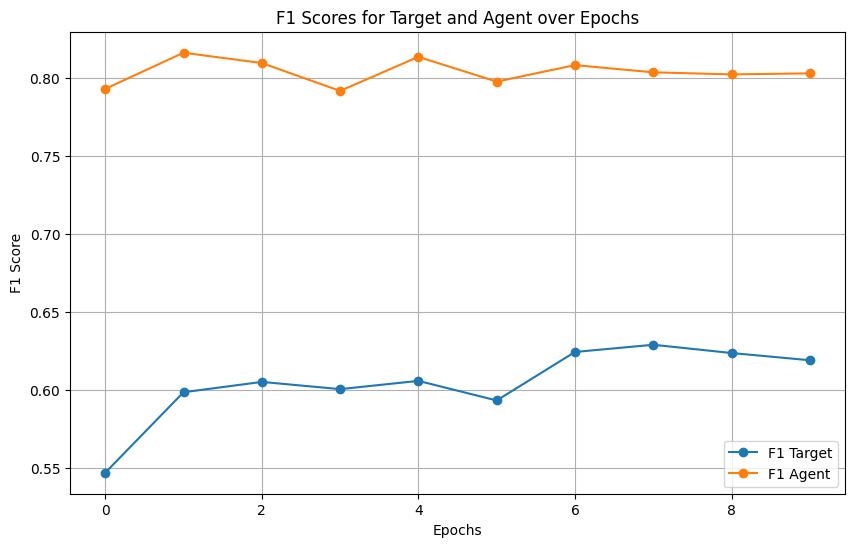

In [24]:
import matplotlib.pyplot as plt
# Plot F1 scores for target and agent
epochs = range(0, EPOCH)

plt.figure(figsize=(10, 6))
plt.plot(epochs, f1_scores_target, label='F1 Target', marker='o')
plt.plot(epochs, f1_scores_agent, label='F1 Agent', marker='o')

plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Target and Agent over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### mpqa fold number:0
### clustering dataset 2k SRL

end of epoch9.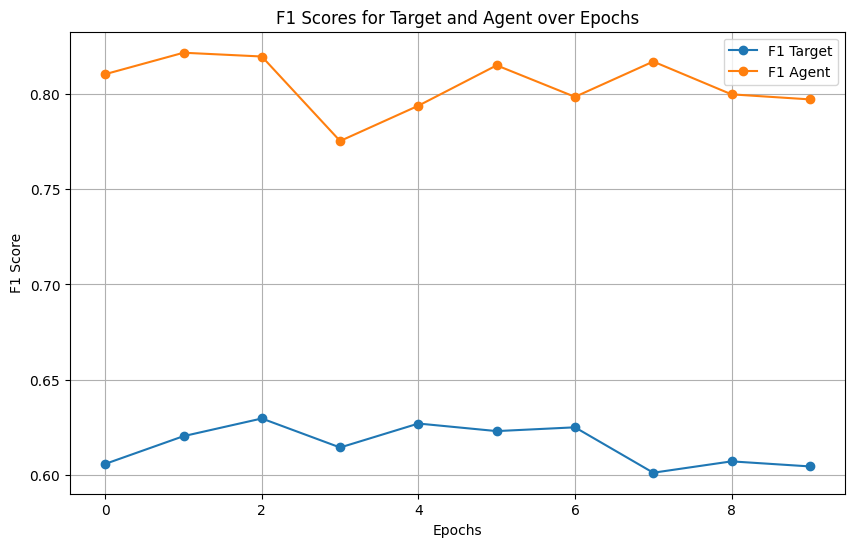

matched: 1379226, prediction_len:2277081, actual_len:2277081 

matched: 1845507, prediction_len:2277081, actual_len:2277081 

loss: 0.9015154256942989, f1 for target:0.6056991385023194, f1 for agent:0.8104705102717031 
 end of epoch0. 

matched: 1412424, prediction_len:2277081, actual_len:2277081 

matched: 1871160, prediction_len:2277081, actual_len:2277081 

loss: 0.21153265294871923, f1 for target:0.6202783300198808, f1 for agent:0.8217362491716369 
 end of epoch1. 

matched: 1433550, prediction_len:2277081, actual_len:2277081 

matched: 1866633, prediction_len:2277081, actual_len:2277081 

loss: 0.13640863791032765, f1 for target:0.629555997349238, f1 for agent:0.8197481776010603 
 end of epoch2. 

matched: 1398843, prediction_len:2277081, actual_len:2277081 

matched: 1765530, prediction_len:2277081, actual_len:2277081 

loss: 0.10450371081023639, f1 for target:0.614314115308151, f1 for agent:0.7753479125248509 
 end of epoch3. 

matched: 1427514, prediction_len:2277081, actual_len:2277081 

matched: 1807782, prediction_len:2277081, actual_len:2277081 

loss: 0.09336628154023803, f1 for target:0.6269052352551359, f1 for agent:0.7939032471835653 
 end of epoch4. 

matched: 1418460, prediction_len:2277081, actual_len:2277081 

matched: 1856070, prediction_len:2277081, actual_len:2277081 

loss: 0.08428306166032824, f1 for target:0.6229290921139827, f1 for agent:0.8151093439363817 
 end of epoch5. 

matched: 1422987, prediction_len:2277081, actual_len:2277081 

matched: 1818345, prediction_len:2277081, actual_len:2277081 

loss: 0.08258093905842438, f1 for target:0.6249171636845593, f1 for agent:0.7985420808482439 
 end of epoch6. 

matched: 1368663, prediction_len:2277081, actual_len:2277081 

matched: 1860597, prediction_len:2277081, actual_len:2277081 

loss: 0.07443194336515603, f1 for target:0.6010603048376408, f1 for agent:0.8170974155069584 
 end of epoch7. 

matched: 1382244, prediction_len:2277081, actual_len:2277081 

matched: 1821363, prediction_len:2277081, actual_len:2277081 

loss: 0.07104971451564379, f1 for target:0.6070245195493704, f1 for agent:0.7998674618952949 
 end of epoch8. 

matched: 1376208, prediction_len:2277081, actual_len:2277081 

matched: 1815327, prediction_len:2277081, actual_len:2277081 

loss: 0.07070050583452503, f1 for target:0.6043737574552683, f1 for agent:0.7972166998011928 

### mpqa fold number:0
### similar verbs 2k random SRL

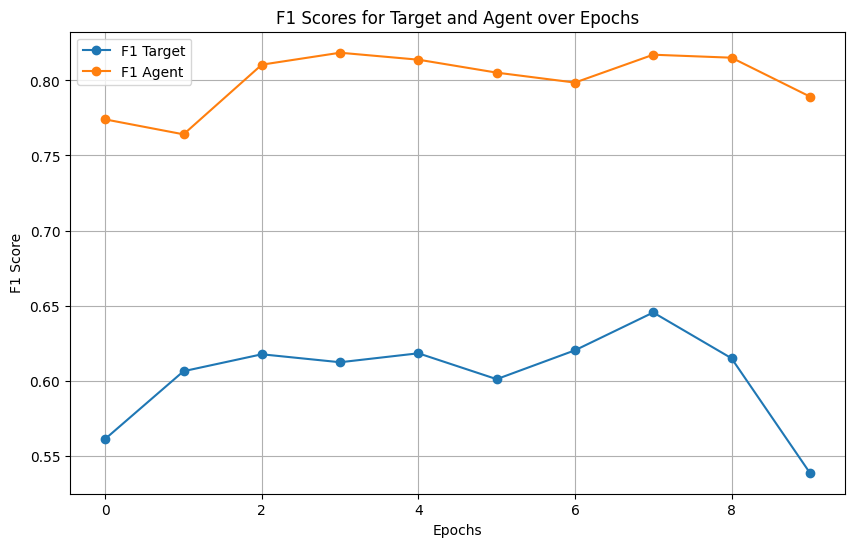

matched: 1278123, prediction_len:2277081, actual_len:2277081 

matched: 1762512, prediction_len:2277081, actual_len:2277081 

loss: 1.0851780722897522, f1 for target:0.56129887342611, f1 for agent:0.7740225314777999 
 end of epoch0. 

matched: 1380735, prediction_len:2277081, actual_len:2277081 

matched: 1739877, prediction_len:2277081, actual_len:2277081 

loss: 0.25361664062419725, f1 for target:0.6063618290258449, f1 for agent:0.7640821736249173 
 end of epoch1. 

matched: 1406388, prediction_len:2277081, actual_len:2277081 

matched: 1845507, prediction_len:2277081, actual_len:2277081 

loss: 0.15891052512963427, f1 for target:0.6176275679257787, f1 for agent:0.8104705102717031 
 end of epoch2. 

matched: 1394316, prediction_len:2277081, actual_len:2277081 

matched: 1863615, prediction_len:2277081, actual_len:2277081 

loss: 0.11553866862631645, f1 for target:0.6123260437375746, f1 for agent:0.8184227965540093 
 end of epoch3. 

matched: 1407897, prediction_len:2277081, actual_len:2277081 

matched: 1853052, prediction_len:2277081, actual_len:2277081 

loss: 0.09510370736000952, f1 for target:0.6182902584493042, f1 for agent:0.8137839628893306 
 end of epoch4. 

matched: 1368663, prediction_len:2277081, actual_len:2277081 

matched: 1833435, prediction_len:2277081, actual_len:2277081 

loss: 0.09350913632718302, f1 for target:0.6010603048376408, f1 for agent:0.805168986083499 
 end of epoch5. 

matched: 1412424, prediction_len:2277081, actual_len:2277081 

matched: 1818345, prediction_len:2277081, actual_len:2277081 

loss: 0.08840858454633009, f1 for target:0.6202783300198808, f1 for agent:0.7985420808482439 
 end of epoch6. 

matched: 1469766, prediction_len:2277081, actual_len:2277081 

matched: 1860597, prediction_len:2277081, actual_len:2277081 

loss: 0.08070311282298426, f1 for target:0.6454605699138503, f1 for agent:0.8170974155069584 
 end of epoch7. 

matched: 1400352, prediction_len:2277081, actual_len:2277081 

matched: 1856070, prediction_len:2277081, actual_len:2277081 

loss: 0.07681847672379237, f1 for target:0.6149768058316766, f1 for agent:0.8151093439363817 
 end of epoch8. 

matched: 1226817, prediction_len:2277081, actual_len:2277081 

matched: 1797219, prediction_len:2277081, actual_len:2277081 

loss: 0.07612742757477874, f1 for target:0.5387673956262425, f1 for agent:0.7892644135188867 
 end of epoch9.

### mpqa fold number:0
#### 2k random srl data + mpqa fold 0 train
#### f1 scores during trainging:

matched: 1293213, prediction_len:2277081, actual_len:2277081 

matched: 1777602, prediction_len:2277081, actual_len:2277081 

loss: 0.882143160694338, f1 for target:0.5679257786613652, f1 for agent:0.780649436713055 
 end of epoch0. 

matched: 1456185, prediction_len:2277081, actual_len:2277081 

matched: 1773075, prediction_len:2277081, actual_len:2277081 

loss: 0.238976030174449, f1 for target:0.6394963552021206, f1 for agent:0.7786613651424784 
 end of epoch1. 

matched: 1406388, prediction_len:2277081, actual_len:2277081 

matched: 1821363, prediction_len:2277081, actual_len:2277081 

loss: 0.14985406012785746, f1 for target:0.6176275679257787, f1 for agent:0.7998674618952949 
 end of epoch2. 

matched: 1285668, prediction_len:2277081, actual_len:2277081 

matched: 1765530, prediction_len:2277081, actual_len:2277081 

loss: 0.1102857322464401, f1 for target:0.5646123260437376, f1 for agent:0.7753479125248509 
 end of epoch3. 

matched: 1356591, prediction_len:2277081, actual_len:2277081 

matched: 1810800, prediction_len:2277081, actual_len:2277081 

loss: 0.10108368237222938, f1 for target:0.5957587806494367, f1 for agent:0.7952286282306164 
 end of epoch4. 

matched: 1465239, prediction_len:2277081, actual_len:2277081 

matched: 1854561, prediction_len:2277081, actual_len:2277081 

loss: 0.09007003453541332, f1 for target:0.6434724983432737, f1 for agent:0.8144466534128563 
 end of epoch5. 

matched: 1489383, prediction_len:2277081, actual_len:2277081 

matched: 1813818, prediction_len:2277081, actual_len:2277081 

loss: 0.07822398539576034, f1 for target:0.6540755467196819, f1 for agent:0.7965540092776673 
 end of epoch6. 

matched: 1406388, prediction_len:2277081, actual_len:2277081 

matched: 1868142, prediction_len:2277081, actual_len:2277081 

loss: 0.07445745206403687, f1 for target:0.6176275679257787, f1 for agent:0.8204108681245859 
 end of epoch7. 

matched: 1413933, prediction_len:2277081, actual_len:2277081 

matched: 1792692, prediction_len:2277081, actual_len:2277081 

loss: 0.07245181024887443, f1 for target:0.6209410205434063, f1 for agent:0.7872763419483101 
 end of epoch8. 

matched: 1429023, prediction_len:2277081, actual_len:2277081 

matched: 1773075, prediction_len:2277081, actual_len:2277081 

loss: 0.07697931850447476, f1 for target:0.6275679257786614, f1 for agent:0.7786613651424784 
 end of epoch9.

### mpqa fold number:4
#### 2k random srl data + mpqa fold 4 train
#### f1 scores during training:

matched: 1329429, prediction_len:2277081, actual_len:2277081 

matched: 1819854, prediction_len:2277081, actual_len:2277081 

loss: 0.9400975324127371, f1 for target:0.5838303512259775, f1 for agent:0.7992047713717695 
 end of epoch0. 

matched: 1336974, prediction_len:2277081, actual_len:2277081 

matched: 1836453, prediction_len:2277081, actual_len:2277081 

loss: 0.24345391458492574, f1 for target:0.587143803843605, f1 for agent:0.8064943671305499 
 end of epoch1. 

matched: 1794201, prediction_len:2277081, actual_len:2277081 

loss: 0.15617759233997391, f1 for target:0.6394963552021206, f1 for agent:0.7879390324718356 
 end of epoch2. 

matched: 1430532, prediction_len:2277081, actual_len:2277081 

matched: 1786656, prediction_len:2277081, actual_len:2277081 

loss: 0.12211952605580835, f1 for target:0.6282306163021869, f1 for agent:0.7846255798542081 
 end of epoch3. 

matched: 1416951, prediction_len:2277081, actual_len:2277081 

matched: 1847016, prediction_len:2277081, actual_len:2277081 

loss: 0.09787583984623023, f1 for target:0.6222664015904572, f1 for agent:0.8111332007952288 
 end of epoch4. 

matched: 1388280, prediction_len:2277081, actual_len:2277081 

matched: 1825890, prediction_len:2277081, actual_len:2277081 

loss: 0.09554016018875826, f1 for target:0.6096752816434725, f1 for agent:0.8018555334658715 
 end of epoch5. 

matched: 1436568, prediction_len:2277081, actual_len:2277081 

matched: 1851543, prediction_len:2277081, actual_len:2277081 

loss: 0.08608145544822247, f1 for target:0.6308813783962889, f1 for agent:0.8131212723658051 
 end of epoch6. 

matched: 1377717, prediction_len:2277081, actual_len:2277081 

matched: 1800237, prediction_len:2277081, actual_len:2277081 

loss: 0.07557136327333781, f1 for target:0.6050364479787939, f1 for agent:0.7905897945659378 
 end of epoch7. 

matched: 1448640, prediction_len:2277081, actual_len:2277081 

matched: 1813818, prediction_len:2277081, actual_len:2277081 

loss: 0.06785838613138571, f1 for target:0.6361829025844931, f1 for agent:0.7965540092776673 
 end of epoch8. 

matched: 1359609, prediction_len:2277081, actual_len:2277081 

matched: 1813818, prediction_len:2277081, actual_len:2277081 

loss: 0.06999738972804494, f1 for target:0.5970841616964877, f1 for agent:0.7965540092776673 
 end of epoch9. 


In [25]:
target_accuracy = evaluate_model(model, test_data_loader, 'target')
agent_accuracy = evaluate_model(model, test_data_loader, 'agent')
print(f'f1 Agent: {agent_accuracy}. f1 Target: {target_accuracy}\n\n----------------------')

matched: 488471, prediction_len:797449, actual_len:797449 

matched: 641174, prediction_len:797449, actual_len:797449 

f1 Agent: 0.8040313549832027. f1 Target: 0.6125419932810751

----------------------


### mpqa fold 0 to 4 
#### average f1 score for agent and target
fold0_agent = 0.8197088465845465
fold0_target = 0.5834266517357223

fold1_agent = 0.7872340425531915
fold1_target = 0.5599104143337066

fold2_agent = 0.7849944008958566
fold2_target = 0.568868980963046

fold3_agent = 0.7950727883538634
fold3_target = 0.5789473684210527

fold4_agent = 0.7939529675251961
fold4_target = 0.571108622620380